# Simple Physical Models for the Global 21-cm Signal

To begin, first import ares and a few standards

In [1]:
%pylab inline
import ares
import matplotlib.pyplot as pl

Populating the interactive namespace from numpy and matplotlib


To generate a model of the global 21-cm signal, we need to use the 
``ares.simulations.Global21cm``  class. With no arguments, default parameter values will be used:

In [2]:
sim = ares.simulations.Global21cm()

# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.

##############################################################################################################
####                                      ARES Simulation: Overview                                       ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Source Populations                                                                                   ####
#### ---------------------------------------------------------------------------------------------------- ####
####               sfrd      sed    radio    O/IR    Ly-a     LW     Ly-C   X-ray    RTE                  ####
#### pop #0  :    fcoll      yes                      x       x                                           ####
#### pop #1  : link:sfrd:0   yes            

Since a lot can happen before we actually  start solving for the evolution of IGM properties (e.g., initializing radiation sources, tabulating the collapsed fraction evolution and constructing splines for interpolation, tabulating the IGM optical depth, etc.), initialization and execution of calculations are separate. 

To run the simulation, we do:

In [3]:
sim.run()

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.


gs-21cm: 100% |###############################################################################| Time:  0:00:02 


The main results are stored in the attribute ``sim.history``, which is a dictionary
containing the evolution of many quantities with time (see [the fields listing](../fields.html)) for more information on what's available). To look at the results,
you can access these quantities directly:

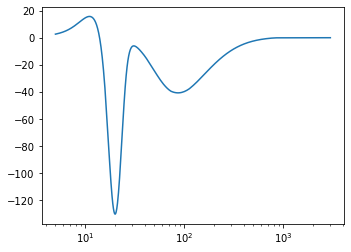

In [4]:
pl.semilogx(sim.history['z'], sim.history['dTb'])

Or, you can access convenience routines within the analysis class, which
is inherited by the ``ares.simulations.Global21cm`` class:

(<AxesSubplot:xlabel='$\\nu \\ (\\mathrm{MHz})$', ylabel='$\\delta T_b \\ (\\mathrm{mK})$'>,
 <AxesSubplot:label='c1faad63-0065-4c61-a43a-028681dedf8a', xlabel='$z$'>)

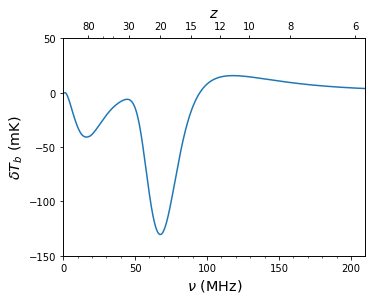

In [5]:
sim.GlobalSignature(fig=2)

If you'd like to save the results to disk, do something like: 

In [6]:
sim.save('test_21cm', clobber=True)

Writing test_21cm.blobs.pkl...
Wrote test_21cm.history.pkl
Writing test_21cm.parameters.pkl...


which saves the contents of ``sim.history`` at all time snapshots to the file ``test_21cm.history.pkl`` and the parameters used in the model in ``test_21cm.parameters.pkl``.

**NOTE:** The default format for output files is ``pkl``, though ASCII (e.g., ``.txt`` or ``.dat``), ``.npz``, and ``.hdf5`` are also supported. Use the optional keyword argument ``suffix``.

If you just want the plot, you can do, e.g.,

In [7]:
pl.figure(2)
pl.savefig('ares_gs_default.png')

<Figure size 432x288 with 0 Axes>

To read results from disk, you can supply a filename *prefix* to ``ares.analysis.Global21cm`` 
rather than a ``ares.simulations.Global21cm`` instance if you'd like, e.g., 

In [8]:
anl = ares.analysis.Global21cm('test_21cm')

See [built-in analysis routines](../analysis.html) for other options.

See the [parameters list](../params.html) to learn about other parameters that can be supplied
to ``ares.simulations.Global21cm`` as keyword arguments.

## 2-D Parameter Study

To do simple parameter study, you could do something like:

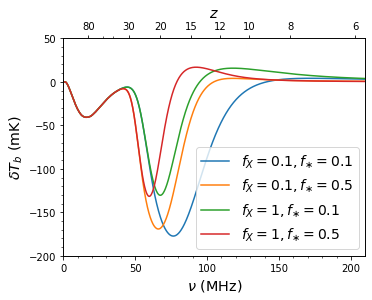

In [9]:
ax = None
for i, fX in enumerate([0.1, 1.]):
    for j, fstar in enumerate([0.1, 0.5]):
        sim = ares.simulations.Global21cm(fX=fX, fstar=fstar, 
            verbose=False, progress_bar=False)
        sim.run()


        # Plot the global signal
        ax, zax = sim.GlobalSignature(ax=ax, fig=3, z_ax=i==j==0,
            label=r'$f_X=%.2g, f_{\ast}=%.2g$' % (fX, fstar))
            
            
ax.legend(loc='lower right', fontsize=14) 
pl.savefig('ares_gs_diy_param_study.png')

These parameters, along with ``Tmin``, ``Nlw``, and ``Nion`` round out the simplest parameterization of the signal (that I'm aware of) that's tied to cosmology/galaxy formation in any way. It's of course highly simplified, in that it treats galaxies in a very average sense. For more sophisticated models, check out [this example](example_pop_galaxy).
                 
Check out [the listing](../params_populations.html) of the most common parameters that govern the properties of source populations, and [](example_grid) for examples of how to run and analyze large grids of models more easily. The key advantage of using the built-in model grid runner is having *ARES* automatically store any information from each calculation that you deem desirable, and store it in a format amenable to the built-in analysis routines.

## A Note About Backward Compatibility

The models shown in this section are no longer the "best" models in *ARES*, though they may suffice depending on your interests. As alluded to at the end of the previous section, the chief shortcoming of these models is that their parameters are essentially averages over the entire galaxy population, when in reality galaxy properties are known to vary with mass and many other properties.

This was the motivation behind [our paper in 2017](http://adsabs.harvard.edu/abs/2017MNRAS.464.1365M), in which we generalized the star formation efficiency to be a function of halo mass and time, and moved to using stellar population synthesis models to determine the UV emissivity of galaxies, rather than choosing $N_{\mathrm{LW}}$, $N_{\mathrm{ion}}$, etc. by hand (see [More Realistic Galaxy Populations](example_pop_galaxy)). These updates led to a new parameter-naming convention in which all population-specific parameters were given a ``pop_`` prefix. So, in place of ``Nlw``, ``Nion``, ``fX``, now one should set ``pop_rad_yield`` in a particular band (defined by ``pop_Emin`` and ``pop_Emax``). See [the parameter listing for populations](params_populations) for more information about that. 

Currently, in order to ensure backward compatibility at some level, *ARES* will automatically recognize the parameters used above and change them to ``pop_rad_yield`` etc. following the new convention. This means that there are three different values of ``pop_rad_yield``: one for the soft UV (non-ionizing) photons (related to ``Nlw``), one for the Lyman continuum photons (related to ``Nion``), and one for X-rays (related to ``fX``). This division was put in place because these three wavelength regimes affect the 21-cm background in different ways.

In order to differentiate sources of radiation in different bands, we now must add a population identification number to ``pop_*`` parameters. Right now, ``fX``, ``Nion``, ``Nlw``, ``Tmin``, and ``fstar`` will automatically be updated in the following way:

- The value of ``Nlw`` is assigned to ``pop_rad_yield{0}``, and ``pop_Emin{0}`` and ``pop_Emax{0}`` are set to 10.2 and 13.6, respectively.
- The value of ``fX`` is multiplied by ``cX`` (generally $2.6 \times 10^{39} \ \mathrm{erg} \ \mathrm{s}^{-1} \ (M_{\odot} \ \mathrm{yr}^{-1})^{-1})$ and assigned to ``pop_rad_yield{1}``, and ``pop_Emin{1}`` and ``pop_Emax{1}`` are set to 200 and 30000, respectively.
- The value of ``Nion`` is assigned to ``pop_rad_yield{2}``, and ``pop_Emin{2}`` and ``pop_Emax{2}`` are set to 13.6 and 24.6, respectively.
- ``pop_Tmin{0}``, ``pop_Tmin{1}``, and ``pop_Tmin{2}`` are all set to the value of ``Tmin``. Likewise for ``fstar``.

Unfortunately not all parameters will be automatically converted in this way. If you get an error message about an "orphan parameter," this means you have supplied a ``pop_`` parameter without an ID number, and so *ARES* doesn't know which population is meant to respond to your change. This is an easy mistake to make, especially when working with parameters like ``Nlw``, ``Nion`` etc., because *ARES* is automatically converting them to ``pop_*`` parameters.